In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Path to your CSV file
file_path = '/Users/sampass/Desktop/IMC Trade Comp/Derivative Strat/Stuff/7967dd9e-ce25-4a3f-83f3-6436994e851a.csv'

# Load the CSV file
data = pd.read_csv(file_path, delimiter=';')

# Creating separate DataFrames for each tradable instrument: Amethysts and Starfruit
amethysts_data = data[data['product'] == 'AMETHYSTS'].copy()
starfruit_data = data[data['product'] == 'STARFRUIT'].copy()

# Setting the 'timestamp' column as the index and keeping only the required columns
amethysts_data.set_index('timestamp', inplace=True)
starfruit_data.set_index('timestamp', inplace=True)

amethysts_data = amethysts_data[['bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price']]
starfruit_data = starfruit_data[['bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price']]

# # Use the timestamps as the independent variable (X)
# X = starfruit_data.index.values  # Independent variable (time)
# y = starfruit_data['mid_price'].values          # Dependent variable (mid_price)

# # Calculate the coefficients for the linear regression line
# X_mean = np.mean(X)
# y_mean = np.mean(y)
# m = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean)**2)
# b = y_mean - m * X_mean

# # Calculate the predicted values using the regression line
# starfruit_data['predicted'] = m * X + b

# Function to calculate linear regression coefficients
def linear_regression(X, y):
    X_mean = np.mean(X)
    y_mean = np.mean(y)
    m = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean)**2)
    b = y_mean - m * X_mean
    return m, b

# Initialize columns for slope, intercept, and predicted price
starfruit_data['m'] = np.nan
starfruit_data['b'] = np.nan
starfruit_data['predicted'] = np.nan

# Rolling calculation of linear regression
for i in range(len(starfruit_data)):
    if i > 0:  # Ensuring there is at least 2 data points to perform regression
        X = starfruit_data.index[:i+1]
        y = starfruit_data['mid_price'].iloc[:i+1].values
        m, b = linear_regression(X, y)
        predicted_price = m * X[-1] + b
        starfruit_data.iloc[i, starfruit_data.columns.get_loc('m')] = m
        starfruit_data.iloc[i, starfruit_data.columns.get_loc('b')] = b
        starfruit_data.iloc[i, starfruit_data.columns.get_loc('predicted')] = predicted_price

starfruit_data.to_csv('starfruit.csv')
amethysts_data.to_csv('amethysts.csv')

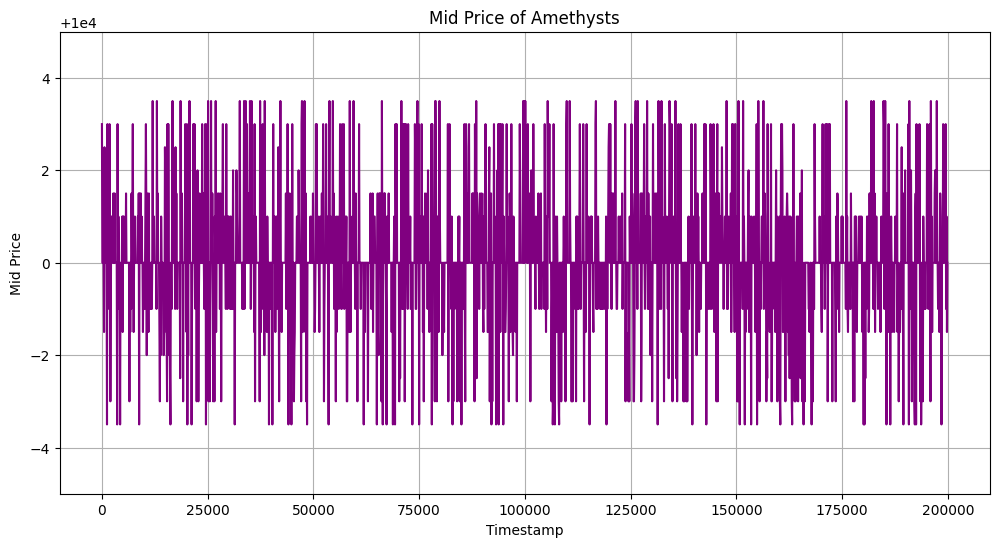

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(amethysts_data.index, amethysts_data['mid_price'], color='purple')
plt.title('Mid Price of Amethysts')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.ylim(9995, 10005)  # Setting the y-axis limits to start at 0 and end a bit above the max value
plt.grid(True)
plt.show()

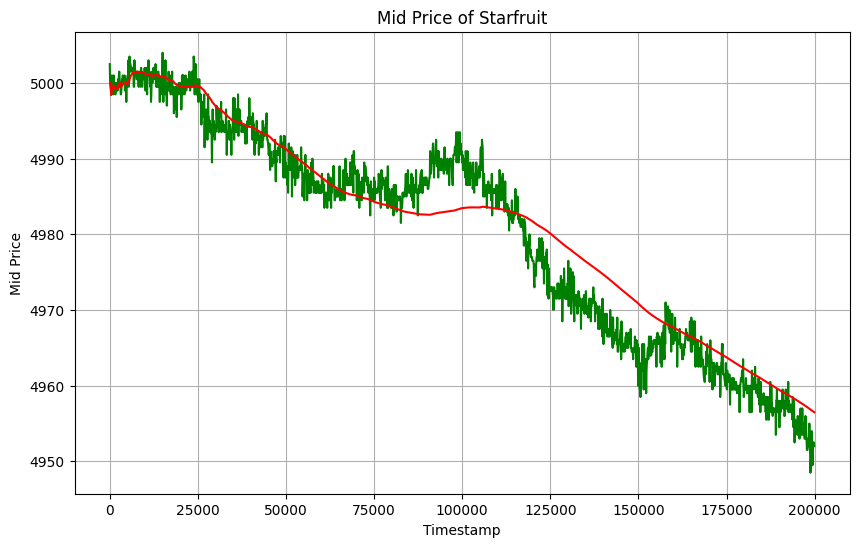

In [5]:
### Plot for Starfruit
plt.figure(figsize=(10, 6))
plt.plot(starfruit_data.index, starfruit_data['mid_price'], color='green')
plt.plot(starfruit_data.index, starfruit_data['predicted'], color='red')
plt.title('Mid Price of Starfruit')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.grid(True)
plt.show()

In [6]:
# Compute the deviation (difference) of the 'mid_price' from the predicted line
starfruit_data['price_deviation'] = starfruit_data['mid_price'] - starfruit_data['predicted']

# Calculate the standard deviation of the deviation
starfruit_data['deviation_std'] = starfruit_data['price_deviation'].rolling(window=20).std()

# Establish Bollinger Bands based on the linear regression line
starfruit_data['upper_band'] = starfruit_data['predicted'] + (starfruit_data['deviation_std'] * 0.3)
starfruit_data['lower_band'] = starfruit_data['predicted'] - (starfruit_data['deviation_std'] * 0.3)

starfruit_data.to_csv('starfruit.csv')

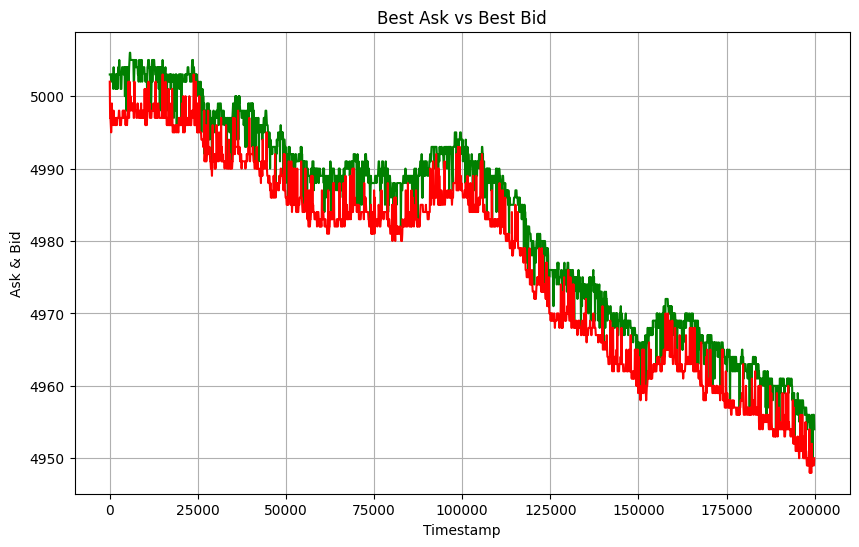

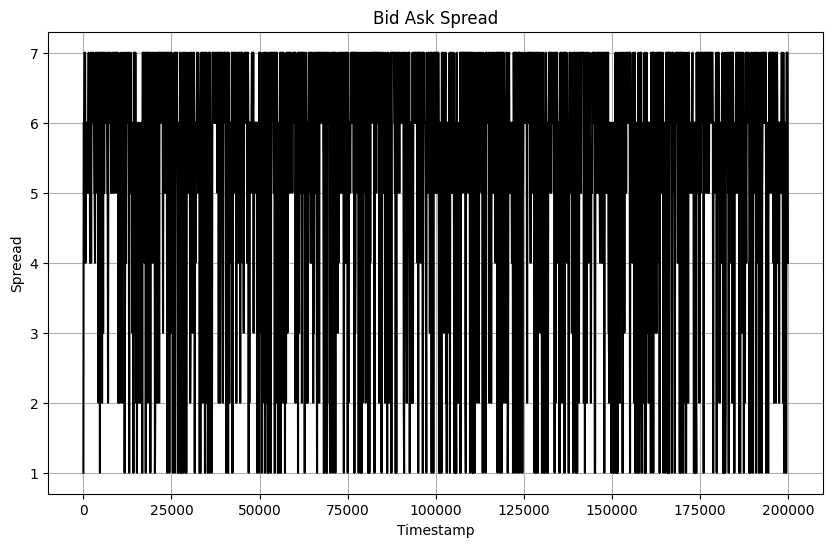

In [23]:
best_ask = starfruit_data['ask_price_1']
best_bid = starfruit_data['bid_price_1']
bid_ask_spread = best_ask - best_bid
plt.figure(figsize=(10, 6))
plt.plot(starfruit_data.index, starfruit_data['ask_price_1'], color='green')
plt.plot(starfruit_data.index, starfruit_data['bid_price_1'], color='red')
plt.title('Best Ask vs Best Bid')
plt.xlabel('Timestamp')
plt.ylabel('Ask & Bid')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(starfruit_data.index, bid_ask_spread, color='black')
plt.title('Bid Ask Spread')
plt.xlabel('Timestamp')
plt.ylabel('Spreead')
plt.grid(True)
plt.show()

In [16]:
daily_returns = []
trade_log = []
position_open = False
position_type = None

for timestamp, row in starfruit_data.iloc[1:].iterrows():
    bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
    ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
    best_bid_price = row['bid_price_1']
    best_bid_volume = row['bid_volume_' + str(bid_prices.index(best_bid_price) + 1)]
    best_ask_price = row['ask_price_1']
    best_ask_volume = row['ask_volume_' + str(ask_prices.index(best_ask_price) + 1)]

    lower_band_value = row['lower_band']
    upper_band_value = row['upper_band']
    predicted_value = row['predicted']
    mid_price = row['mid_price']
    
    # Open position logic
    if mid_price < lower_band_value and not position_open:
        # Open short position at best ask
        trade_log.append({
            'Date': timestamp,
            'Action': 'Open Position',
            'Type': 'Long',
            'Shares': 1,
            'Price': best_ask_price,
        })
        position_open = True
        position_type = 'Long'

    elif mid_price > upper_band_value and not position_open:
        # Open long position at best bid
        trade_log.append({
            'Date': timestamp,
            'Action': 'Open Position',
            'Type': 'Short',
            'Shares': 1,
            'Price': best_bid_price,
        })
        position_open = True
        position_type = 'Short'
    
    elif mid_price > predicted_value and position_open and position_type == 'Long':
        trade_log.append({
            'Date': timestamp,
            'Action': 'Close Position',
            'Type': 'Long',
            'Shares': 1,
            'Price': best_bid_price,
        })
        position_open = False
        
    elif mid_price < predicted_value and position_open and position_type == 'Short':
        trade_log.append({
            'Date': timestamp,
            'Action': 'Close Position',
            'Type': 'Short',
            'Shares': 1,
            'Price': best_ask_price,
        })
        position_open = False

# Save the trade log to a DataFrame and then to a csv file
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [17]:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []

for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'Long':
            profit_loss = (trade['Price'] - open_position['Price']) * open_position['Shares']
        elif open_position['Type'] == 'Short':
            profit_loss = (open_position['Price'] - trade['Price']) * open_position['Shares']
        
        total_return += profit_loss
        close_position_returns.append(profit_loss)

        open_position = None

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

print(f"Total return from strategy: {total_return}")

Total return from strategy: -334.0


In [18]:
profit_loss_df = pd.read_csv('returns.csv')

daily_returns = profit_loss_df['Profit/Loss'] / 5000

average_daily_return = daily_returns.mean()

annual_risk_free_rate = 0.02

daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1

excess_daily_returns = daily_returns - daily_risk_free_rate

std_dev_excess_daily_returns = excess_daily_returns.std()

sharpe_ratio = (excess_daily_returns.mean() / std_dev_excess_daily_returns) * (252 ** 0.5)

print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: -16.537771522558952


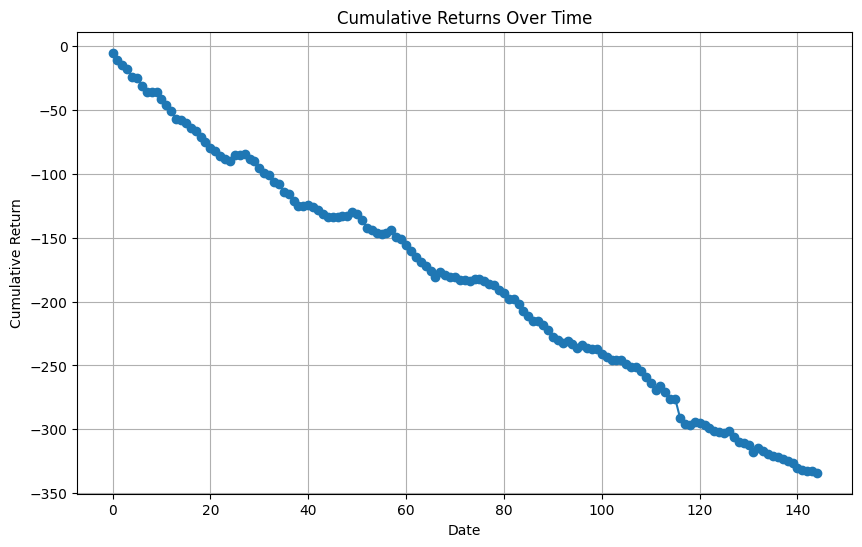

In [19]:
# Calculate cumulative returns
profit_loss_df['Cumulative Return'] = profit_loss_df['Profit/Loss'].cumsum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(profit_loss_df['Cumulative Return'], marker='o')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

In [5]:
order_quantity = min(abs(-40), abs(-50), 19)
print(order_quantity)

19


In [6]:
print(-abs(order_quantity))

-19
